In [ ]:
! python3 setup.py build_ext --inplace

In [18]:
import numpy as np
import jfield
import transform as tr
import matplotlib.pyplot as plt

In [27]:
data = np.loadtxt('Example Data/PERI-01-pc.dat')
x_jso = np.loadtxt('Example Data/PERI-01-ss.dat')[:,2] / jfield.params.RJ

R = np.sqrt(data[:,2] ** 2 + data[:,3] ** 2 + data[:,4] ** 2) / jfield.params.RJ

R_max = 60

mask = np.where(R < R_max)[0]
subsample = 5
data = (data[mask,:])[::subsample, :]
x_jso = (x_jso[mask])[::subsample]
R = (R[mask])[::subsample]
R1 = np.array(R)
R1[:R.argmin()] = -R1[:R.argmin()]

In [20]:
coords_SIII_cart = np.transpose(data[:,2:5] / jfield.params.RJ)
coords_SIII_sph = tr.coords_cart2sph(coords_SIII_cart)
coords_M_cart = jfield.SIII2M(coords_SIII_cart)
coords_M_cyl = tr.coords_cart2cyl(coords_M_cart)

B_obs_SIII_cart = np.transpose(data[:,5:8])
B_obs_M_cart = jfield.SIII2M(B_obs_SIII_cart)
B_obs_M_cyl = tr.vectors_cart2cyl(B_obs_M_cart, coords_M_cart)

In [21]:
B_int_SIII_sph = jfield.internal_field(coords_SIII_sph[0], coords_SIII_sph[1], coords_SIII_sph[2])
B_int_SIII_cart = tr.vectors_sph2cart(B_int_SIII_sph, coords_SIII_sph)
B_int_M_cart = jfield.SIII2M(B_int_SIII_cart)
B_int_M_cyl = tr.vectors_cart2cyl(B_int_M_cart, coords_M_cart)

In [24]:
rho, phi, z = coords_M_cyl
B_md_M_cyl = jfield.PCD_field(rho, phi, z, x_jso)

<IPython.core.display.Javascript object>


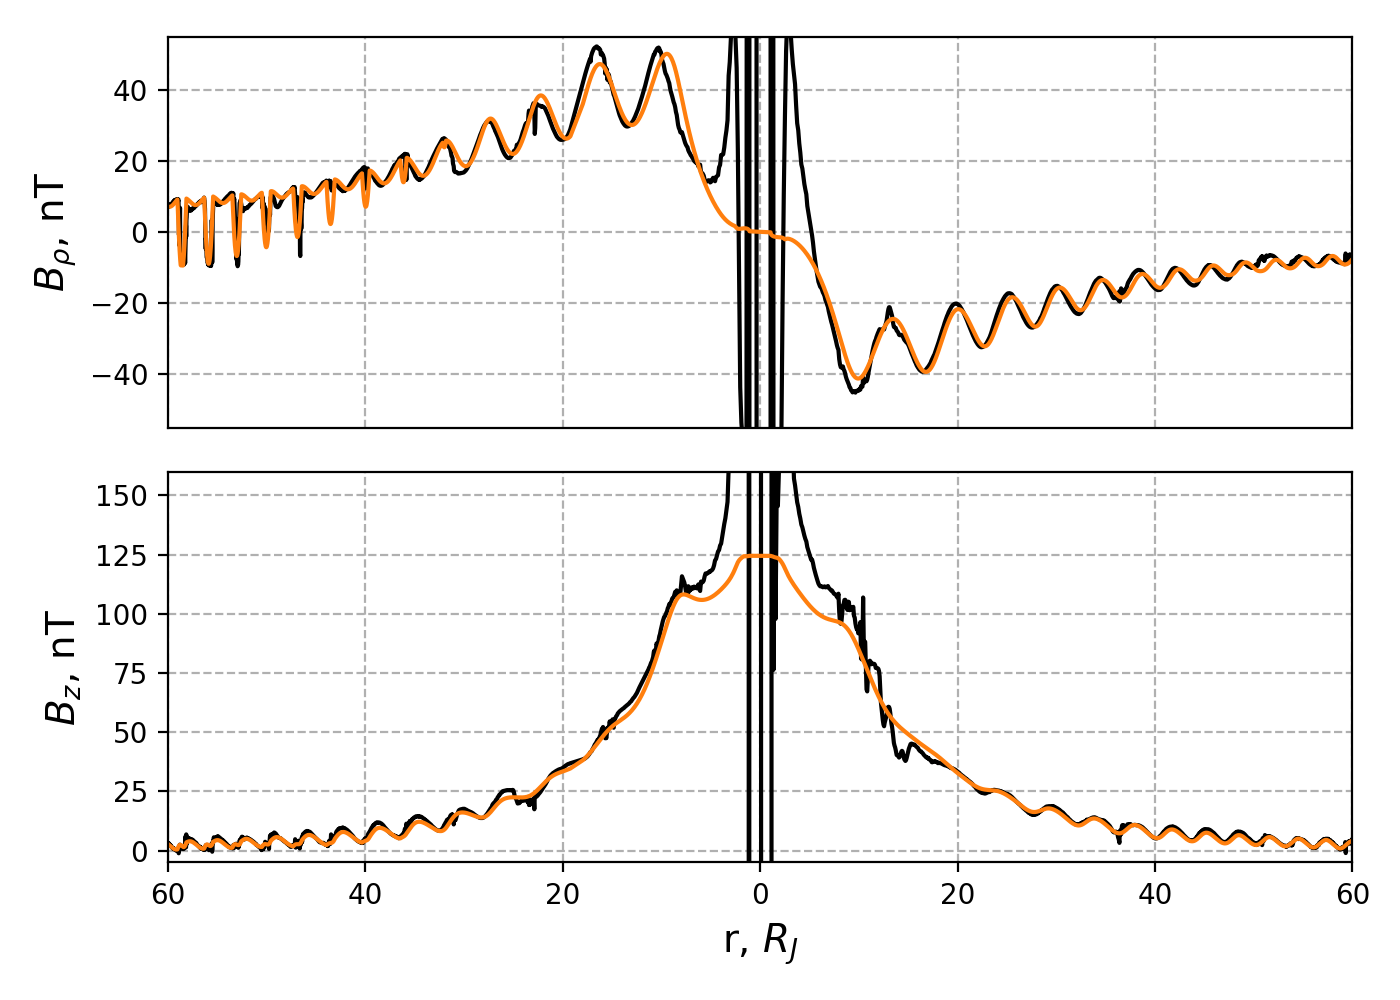

In [23]:
%matplotlib notebook

c_ob = 'black'
c_md = '#ff7f0e'

figure, (ax1, ax2) = plt.subplots(2,1,figsize=(7,5))
ax1.plot(R1, B_obs_M_cyl[0] - B_int_M_cyl[0], color = c_ob)
ax1.plot(R1, B_md_M_cyl[0], color = c_md)

ax2.plot(R1, B_obs_M_cyl[2] - B_int_M_cyl[2], color = c_ob)
ax2.plot(R1, B_md_M_cyl[2], color = c_md)

ax1.set_ylim(-55, 55)
ax2.set_ylim(-5, 160)
ax1.set_xlim(-R_max, R_max)
ax2.set_xlim(-R_max, R_max)
ax1.grid(linestyle = '--')
ax2.grid(linestyle = '--')

ax1.set_ylabel(r'$B_{\rho}$, nT', fontsize = 14)
ax2.set_ylabel(r'$B_{z}$, nT', fontsize = 14)
ax2.set_xlabel('r, $R_J$', fontsize = 14)
ax1.set_xticklabels([])
for tic in ax1.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
def tick_function(X):
    return ["%.0f" % np.abs(z) for z in X]
ax2.set_xticklabels(tick_function(plt.xticks()[0]))

figure.tight_layout()